# Table of Contents
* [load data](#load-data)
* [process data](#process-data)
	* [bonuses](#bonuses)
	* [frame build](#frame-build)
	* [analysis](#analysis)
	* [building frames](#building-frames)
* [bounding box clustering](#bounding-box-clustering)
* [bonus cost estimate](#bonus-cost-estimate)
* [HTML Review](#HTML-Review)
* [hide](#hide)


In [21]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import re
import pickle
import boto
from copy import deepcopy
import json
import os
import random
import jinja2
from tqdm import tqdm
from IPython.core.display import HTML

import PIL.Image as Image
import requests

from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo

from amt_utils.mturk import pickle_this, unpickle_this

import os
import jinja2
import argparse
from jinja2 import Environment, FileSystemLoader

j2env = jinja2.Environment()

from amt_utils.bboxes import cluster_from_nms
from amt_utils.bboxes import draw_animation_seq
from amt_utils.bboxes import cluster_from_annos
from amt_utils.bboxes import create_subtask_data
from amt_utils.bboxes import draw_image_and_labels
from amt_utils.bboxes import cluster_and_label

import warnings
warnings.filterwarnings('ignore')

# load data

In [2]:
data_paths = ['./pickeled_results/turker_batch_{}.pkl'.format(i) for i in range(1, 6)]

turk_data_assemble = [unpickle_this(data_path) for data_path in data_paths]

turk_data = {}
_ = [turk_data.update(data_part) for data_part in turk_data_assemble]

batch_2 = turk_data_assemble[1]
batch_3 = turk_data_assemble[2]
batch_4 = turk_data_assemble[3]
batch_5 = turk_data_assemble[4]

In [36]:
len(subtask_data)

1088

In [ ]:
len(b)

In [54]:
len(batch_7)

1088

In [40]:
batch_6 = unpickle_this('./pickeled_results/turker_batch_6_subtask.pkl')
batch_7 = unpickle_this('./pickeled_results/turker_batch_7_subtask.pkl')
# all_subtask = unpickle_this('./pickeled_results/turker_all_subtask_8_12.pkl')

subtask_data_assemble = [batch_6, batch_7]

In [54]:
prod_1_4 = unpickle_this('stage1b_prod_1_4_prelim.pkl')

In [42]:
len(batch_6) + len(batch_7)

1354

In [43]:
subtask_data = {}
_ = [subtask_data.update(data_part) for data_part in subtask_data_assemble]

In [45]:
# len(all_so_far) * 3

In [68]:
with open('./complete_subtask_clips_8_12.txt', 'r') as f:
    subtask_complete = f.read()

subtask_complete = set(subtask_complete.split())

In [76]:
with open('./complete_subtask_clips_8_12.txt', 'a') as f:
    import csv
    cw = csv.writer(f, delimiter=' ')
    cw.writerow(list(subtask_by_frame.keys()))

In [6]:
latest_results = unpickle_this('latest_result_group_8_16.pkl')

In [7]:
len(latest_results)

29770

# process data

In [9]:
main_characters =  {"fred",
             "barney",
              "wilma",
              "betty",
              "pebbles",
              "bamm bamm",
              "dino",
              "mr slate",
              "baby puss",
              "hoppy",
              "empty frame",
              "no characters"}

def create_result(assmt):
    result = json.loads(assmt.answers[0][0].fields[0])
    result['h_id'] = assmt.HITId
    result['worker_id'] = assmt.WorkerId
    return result


def all_main(char_set, main_chars=main_characters):
    return not bool(char_set.difference(main_chars))

In [68]:
assignments =[]
for assignment_triple in list(prod_1_4.values()) + list(subtask_data.values()):
    assignments.extend(assignment_triple)

assignment_results = [create_result(ar) for ar in assignments]
characters_present = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

In [69]:
pd.Series([len(a) for a in prod_1_4.values()]).value_counts()

3    29631
6        1
dtype: int64

In [62]:
len(assignments)

88899

## build frames

In [70]:
annotations_by_frame = defaultdict(list)
for anno in sorted(assignment_results, key=lambda x: x['stillID']):
    animation_id = anno['stillID'].rsplit('_', 1)[0]
    annotations_by_frame[animation_id].append(anno)

In [71]:
len(annotations_by_frame)

19272

# analysis

In [12]:
char_df = pd.DataFrame(characters_present)
char_df['aid'] = char_df['still_id'].apply(lambda x: x.rsplit('_', 1)[0])
char_df['all_main'] = char_df['characters'].apply(lambda x: all_main(x))
char_df['n_chars'] = char_df['characters'].apply(lambda x: len(x))
all_chars = [c for char_list in char_df['characters'].apply(lambda x: list(x)).tolist() for c in char_list]

In [13]:
grouped_by_still = char_df.groupby('still_id')
agg_df = grouped_by_still.aggregate(len)

agged_on_mode = grouped_by_still.agg(lambda x: st.mode(x))

In [14]:
consensus_results_df = agged_on_mode.reset_index()

consensus_results_df['count_mode'] = consensus_results_df['n_chars'].apply(lambda x: x[1][0])
consensus_results_df['mode_count'] = consensus_results_df['characters'].apply(lambda x: x[1][0])

consensus_results_df['all_agree'] = consensus_results_df['count_mode'] == 3
consensus_results_df['two_agree'] = consensus_results_df['count_mode'] == 2

char_count_df = consensus_results_df[consensus_results_df['count_mode'] == 3]

agree_all_main = consensus_results_df['all_main'].apply(lambda x: x[1][0]) == 3 

not_main =set(consensus_results_df[~agree_all_main]['still_id'].tolist())
not_main_df = char_df[char_df['still_id'].isin(not_main)]


all_agree = consensus_results_df[agree_all_main][consensus_results_df[agree_all_main]['all_agree']]
disagree = consensus_results_df[agree_all_main][~consensus_results_df[agree_all_main]['all_agree']]

all_agree_set = set(all_agree['still_id'].tolist())

count_all_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 3]['still_id'].tolist())
count_two_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 2]['still_id'].tolist())
count_none_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 1]['still_id'].tolist())

conflict_images = set(disagree['still_id'].tolist())

conflict_df = char_df[char_df['still_id'].isin(conflict_images)]

In [15]:
600 * 3 * 3

5400

In [16]:
char_df.shape[0] * 0.05

311.1

In [17]:
char_counts = pd.Series(all_chars).value_counts()

In [751]:
char_counts

fred                                                 8747
barney                                               5021
wilma                                                3855
empty frame                                          3795
betty                                                2010
mr slate                                              797
dino                                                  616
pebbles                                               593
bamm bamm                                             218
hoppy                                                 154
old man                                                60
baby puss                                              53
man                                                    43
circus performer                                       27
the man dress color is brown                           26
the man was standing                                   24
bird                                                   21
construction w

In [752]:
char_counts[char_counts < 16].sum()

2458

In [753]:
322 * 0.02

6.44

In [754]:
tes = set([])

In [755]:
bool(tes)

False

In [757]:
#  char_df['characters'].apply(lambda x:x.difference(set(empty_characters)))

In [758]:
char_df['empty'] = ~char_df['characters'].apply(lambda x:bool(x.difference(set(empty_characters))))

In [759]:
char_df['nonmain_characters'] = char_df['characters'].apply(lambda x: len(x.difference(set(main_characters))))

In [760]:
grouped_by_aid = char_df.groupby('aid')

In [761]:
grouped_by_aid.agg(max)['nonmain_characters'].sum()

1326

In [762]:
grouped_by_aid.agg(max).shape

(2152, 8)

In [763]:
grouped_by_aid.agg(max)['nonmain_characters'].sum() * 3 * 3  * 0.02

238.68000000000001

In [764]:
char_df.shape[0] * 0.04

774.16

In [45]:
# grouped_by_aid.agg(max)[grouped_by_aid.agg(min)['empty'] == True]

In [767]:
grouped_by_aid.agg(min)['empty'].sum()

34

In [667]:
grouped_by_aid.agg(max).shape

(700, 8)

# process subtask

In [82]:
subtask_assignments =[]
for assignment_triple in list(prod_1_4.values()) + list(subtask_data.values()):
    subtask_assignments.extend(assignment_triple)

subtask_results = [create_result(ar) for ar in subtask_assignments]
characters_boxes = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in subtask_results]

In [83]:
subtask_by_frame = defaultdict(list)
for anno in sorted(subtask_results, key=lambda x: x['stillID']):
    animation_id = anno['stillID'].rsplit('_', 1)[0]
    subtask_by_frame[animation_id].append(anno)

In [84]:
len(subtask_by_frame)

19272

In [86]:
subtask_by_frame['s_02_e_07_shot_010402_010476']

[{'characterBoxes': '[{"left":450,"top":154,"width":101,"height":216,"label":"s_02_e_07_shot_010402_010476_char_3_taskb.png"},{"left":347,"top":154,"width":106,"height":227,"label":"s_02_e_07_shot_010402_010476_char_3_taskb.png"},{"left":229,"top":180,"width":100,"height":188,"label":"s_02_e_07_shot_010402_010476_char_3_taskb.png"},{"left":93,"top":138,"width":128,"height":272,"label":"s_02_e_07_shot_010402_010476_char_3_taskb.png"},{"left":715,"top":115,"width":124,"height":253,"label":"s_02_e_07_shot_010402_010476_char_3_taskb.png"},{"left":864,"top":166,"width":102,"height":169,"label":"s_02_e_07_shot_010402_010476_char_3_taskb.png"},{"left":1004,"top":146,"width":92,"height":229,"label":"s_02_e_07_shot_010402_010476_char_3_taskb.png"},{"left":1090,"top":126,"width":103,"height":279,"label":"s_02_e_07_shot_010402_010476_char_3_taskb.png"}]',
  'h_id': '32ZCLEW0B0K87A98G8936329YUVJP6',
  'stillID': 's_02_e_07_shot_010402_010476_taskb.png',
  'worker_id': 'A2PU4YNWITAQVL'},
 {'charact

In [75]:
rev_dir = 'review_results'
img_dir = 'review_frames'

In [76]:
char_change = defaultdict(list)
for aid, annos in list(subtask_by_frame.items()):
    disapear_count = 0
    for anno in annos:
        la = json.loads(anno['characterBoxes'])
        if len(la) !=2:
            disapear_count += 1
    if disapear_count == 3:
        char_change[aid].append(la)

In [77]:
list(char_change.items())[0]

('s_01_e_01_shot_014223_014297',
 [[{'height': 371,
    'label': 's_01_e_01_shot_014223_014297_char_0_taskb.png',
    'left': 672,
    'top': 101,
    'width': 244}]])

In [47]:
1108/ len(subtask_by_frame)

0.059387897303960976

In [44]:
len(char_change)

1108

In [126]:
task_r_lengths = pd.Series([len(sta) for sta in list(subtask_by_frame.values())])

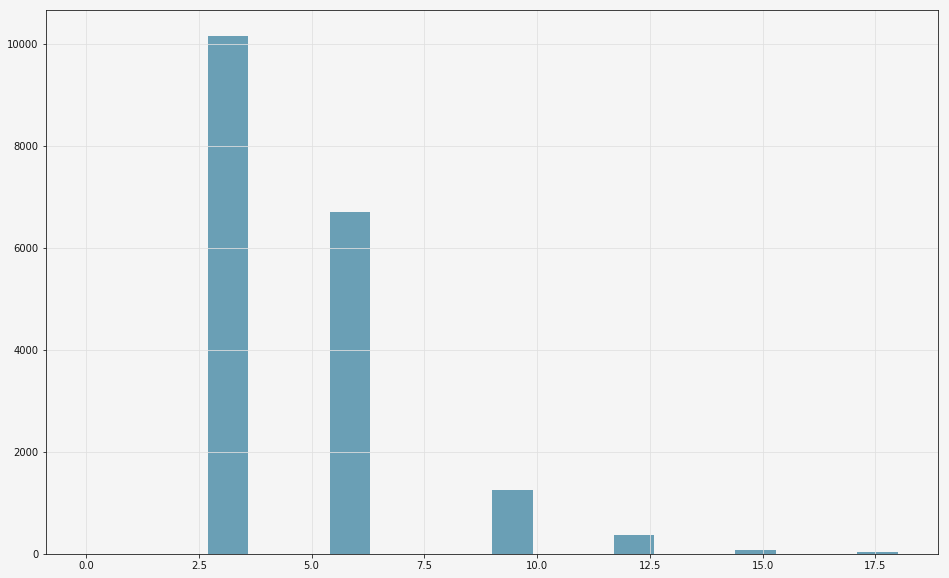

In [130]:
task_r_lengths[task_r_lengths < 20].hist(bins=20)

In [18]:
# subtask_rev_seq = []
# stage_1b_consensus_boxes = {}
# for aid, animation_annos in tqdm(list(subtask_by_frame.items())[:51]):
#     try:
#         middle_frame_annos = annotations_by_frame[aid][3:6]
#         full_original_annos = annotations_by_frame[aid]
#         two_frame_image, con_boxes, labels = draw_image_and_labels(animation_annos, cluster_from_nms, 1, 3, './subtask_data/frames/')
#         three_frame_img, consensus_boxes, labels_orig = draw_animation_seq(full_original_annos, cluster_from_nms)
#         single_frame_image, single_con_boxes, labels = draw_image_and_labels(middle_frame_annos, cluster_from_nms, 1, 3)
#         left_image = two_frame_image.crop(frame_origin + frame_size)
#         right_image = two_frame_image.crop(frame_o2 + frame_ext)
#         imgs_comb = Image.fromarray(np.hstack([left_image, single_frame_image, right_image]))
#         o_img_path = os.path.join(img_dir, aid) + '_rev.png'
#         new_img_path = os.path.join(img_dir, aid) + 'subtask_rev.png'
#         three_frame_img.save(os.path.join(rev_dir, o_img_path))
#         imgs_comb.save(os.path.join(rev_dir, new_img_path))
#         subtask_rev_seq.append((aid, o_img_path, new_img_path))
#     except:
#         print(aid)

In [121]:
frame_origin = (0, 0)
frame_size = (640, 480)
frame_o2 = (640, 0)
frame_ext = (1280, 480)

In [79]:
len(subtask_by_frame)

19272

In [87]:
subtask_consensus_boxes = {}
for aid, animation_annos in tqdm(list(subtask_by_frame.items())):
    try:
        con_boxes, labels = cluster_and_label(animation_annos, cluster_from_nms, 1, 3, './subtask_data/frames/')
        subtask_consensus_boxes[aid] = con_boxes
    except:
        print(aid)

 57%|█████▋    | 11077/19273 [00:09<00:07, 1131.84it/s]

s_04_e_04_shot_026741_026815


100%|██████████| 19273/19273 [00:17<00:00, 1088.68it/s]

s_02_e_07_shot_010402_010476_taskb


In [80]:
pickle_this(subtask_consensus_boxes, 'processed_subtask_boxes.pkl')

In [105]:
len(json.loads(subtask_by_frame['s_02_e_07_shot_010402_010476'][0]['characterBoxes']))

8

In [89]:
subtask_consensus_boxes['s_02_e_07_shot_010402_010476']

[{'area': 34816,
  'box': array([ 93, 138, 221, 410]),
  'idx': 3,
  'label': 's_02_e_07_shot_010402_010476_char_3_taskb.png',
  'votes': 4},
 {'area': 31372,
  'box': array([715, 115, 839, 368]),
  'idx': 4,
  'label': 's_02_e_07_shot_010402_010476_char_3_taskb.png',
  'votes': 4},
 {'area': 28737,
  'box': array([1090,  126, 1193,  405]),
  'idx': 7,
  'label': 's_02_e_07_shot_010402_010476_char_3_taskb.png',
  'votes': 4},
 {'area': 21816,
  'box': array([450, 154, 551, 370]),
  'idx': 0,
  'label': 's_02_e_07_shot_010402_010476_char_3_taskb.png',
  'votes': 4},
 {'area': 21068,
  'box': array([1004,  146, 1096,  375]),
  'idx': 6,
  'label': 's_02_e_07_shot_010402_010476_char_3_taskb.png',
  'votes': 4},
 {'area': 19350,
  'box': array([350, 151, 436, 376]),
  'idx': 22,
  'label': 's_02_e_07_shot_010402_010476_char_2_taskb.png',
  'votes': 4},
 {'area': 18800,
  'box': array([229, 180, 329, 368]),
  'idx': 2,
  'label': 's_02_e_07_shot_010402_010476_char_3_taskb.png',
  'votes': 3

In [44]:
page_html = generate_subtask_review(subtask_rev_seq)

In [100]:
len(subtask_by_frame)

1632

In [48]:
# with open('complete_subtask_clips.txt', 'a') as f:
#     import csv
#     cw = csv.writer(f, delimiter=' ')
#     cw.writerow(list(subtask_by_frame.keys()))

# bounding box clustering

In [ ]:
rev_dir = 'review_results'
img_dir = 'review_frames'

In [109]:
review_seq = {}
error_frames = []
for aid, animation_annos in tqdm(list(annotations_by_frame.items())[:500]):
    try:
        three_frame_img, consensus_boxes, labels = draw_animation_seq(animation_annos, cluster_from_nms)
        avg_votes = np.mean([box['votes'] for frame in consensus_boxes for box in frame])
        possible_labels = [c['possible_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
        chosen_labels = [c['chosen_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
        review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
        img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
        three_frame_img.save(img_path)
    except:
        error_frames.append(aid)

rev_page = generate_review_page('bbox_review_new_8_7_small.html')

100%|██████████| 500/500 [00:21<00:00, 23.56it/s]


## debug

In [ ]:
# review_seq = {}
# error_frames = []
# n = 0
# for aid, animation_annos in list(debug_sample.items()):
#     print(aid)
# #     try:
#     three_frame_img, consensus_boxes = draw_animation_seq(animation_annos, cluster_from_nms)
#     avg_votes = np.mean([box['votes'] for frame in consensus_boxes for box in frame])
#     possible_labels = [c['possible_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
#     chosen_labels = [c['chosen_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
#     review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
#     img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
#     three_frame_img.save(img_path)
# #     except IndexError:
# #         error_frames.append(aid)

# rev_page = generate_review_page('bbox_review_new_8_7_debug.html')
# rev_page = rev_page.replace('review_frames', 'review_results/review_frames').replace('.png', '.png?arg' + str(random.randint(0, 100000000)))
# HTML(rev_page)

In [23]:
0.911843854359 * 1.6

1.4589501669744

In [29]:
debug_clips = ['s_01_e_06_shot_020535_020609', 's_01_e_05_shot_009896_009970', 's_01_e_06_shot_025311_025385', 's_01_e_07_shot_014729_014803', 's_01_e_06_shot_032983_033057']
debug_clips = ['s_01_e_04_shot_016588_016662', 's_01_e_05_shot_009896_009970', 's_01_e_06_shot_020535_020609', 's_01_e_01_shot_022792_022866']
debug_clips = ['s_01_e_06_shot_020535_020609']
debug_clips += ['s_01_e_01_shot_022792_022866']
debug_clips += ['s_01_e_05_shot_002673_002747']
debug_clips += ['s_01_e_06_shot_007192_007266']
debug_clips += ['s_01_e_05_shot_004222_004296']

debug_sample = {debug_clip: annotations_by_frame[debug_clip] for debug_clip in debug_clips}

In [30]:
error_clip = list(annotations_by_frame.values())[0]

three_frames = [s3_base_path + error_clip[i]['stillID'] for i in [0, 6]]
imgs_comb = np.hstack([Image.open(requests.get(image_url, stream=True).raw) for image_url in three_frames])
test_image = Image.fromarray(imgs_comb)

In [26]:
test_image.size

NameError: name 'test_image' is not defined

In [996]:
annotations_by_frame['s_01_e_19_shot_025542_025616']

[]

# bonus cost estimate

In [197]:
main_characters = [
    "Fred",
    "Wilma",
    "Mr Slate",
    "Barney",
    "Betty",
    "Pebbles",
    "Dino",
    "Baby Puss",
    "Hoppy",
    "Bamm Bamm",
]

empty_characters = ['no characters', 'empty frame']
main_characters += empty_characters
main_characters = [char.lower() for char in main_characters]

In [183]:
frame_cost = 0
bonus_cost = 0
for anno in list(review_seq.values()):
    frame_cost += 0.05 * 3
#     print(anno)
    bonus_cost += len([char for char in anno['chosen_labels'] if char not in main_characters]) * 0.03

In [184]:
print(frame_cost, bonus_cost)
frame_cost + bonus_cost

80.25000000000018 3.659999999999995


83.91000000000018

In [200]:
frame_count = []
for anno in list(review_seq.values()):
    frame_count += len([char for char in anno['chosen_labels'] if char not in empty_characters])

In [201]:
frame_count

787

# HTML Review

In [30]:
review_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h3>score: {{clip[2]}}      rank: {{clip[3]}}</h3>
        <p>{{clip[1]}}</p>
        <p>{{clip[4]}}</p>
        <p>{{clip[5]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""


review_subtask_comp = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h4>original 3 frames:</h4>
        <p>{{clip[1]}}</p>
        <h4>new frames + original middle:</h4>
        <p>{{clip[2]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

In [39]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

def make_uri(clip_id, s3_base='review_frames', file_ext='_rev.png'):
    s3_uri = s3_base + clip_id + file_ext
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag

def make_comp_uri(clip_id, s3_base='./'):
    s3_uri = s3_base + clip_id
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag


def generate_review_page(out_page='bbox_review.html'):
    images_sorted_by_conf = [make_uri(img[0]) for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    sorted_clip_ids = [img[0] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    votes = [img[1]['votes'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    chosen_labels = [img[1]['chosen_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    possible_labels = [img[1]['possible_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    
    send_to_template = zip(sorted_clip_ids, images_sorted_by_conf, votes, range(1, len(votes) + 1)[::-1], chosen_labels, possible_labels)
    env = Environment()
    template =  j2env.from_string(review_page_html)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = send_to_template)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
    return page_html


def generate_subtask_review(rev_seq, out_page='review_subtask_comp.html'):
    env = Environment()
    rev_seq = [(rev[0], make_comp_uri(rev[1]), make_comp_uri(rev[2])) for rev in rev_seq]
    template =  j2env.from_string(review_subtask_comp)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = rev_seq)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
        
    return page_html

In [32]:
page_html = generate_subtask_review(subtask_rev_seq)

# hide

In [ ]:
vote_series = pd.Series([vote for vote in review_seq.values()])

In [13]:
# assignments =[]
# for assignment_triple in list(results.values()):
#     assignments.extend(assignment_triple)

# assignment_results = [create_result(ar) for ar in assignments]

# characters_present = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

# main_characters =  {"fred",
#              "barney",
#               "wilma",
#               "betty",
#               "pebbles",
#               "bamm bamm",
#               "dino",
#               "mr slate",
#               "baby puss",
#               "hoppy",
#               "no characters"}

# def all_main(char_set, main_chars=main_characters):
#     return not bool(char_set.difference(main_chars))

# char_df = pd.DataFrame(characters_present)

# char_df['all_main'] = char_df['characters'].apply(lambda x: all_main(x))

# all_chars = [c for char_list in char_df['characters'].apply(lambda x: list(x)).tolist() for c in char_list]
# char_counts = pd.Series(all_chars).value_counts()

# # char_counts.hist(bins = 30, log=True)

# char_df['n_chars'] = char_df['characters'].apply(lambda x: len(x))

# prolific_workers = char_df['w_id'].value_counts().index.tolist()[:5]

# grouped_by_still = char_df.groupby('still_id')

# agg_df = grouped_by_still.aggregate(len)

# import scipy

# agged_on_mode = grouped_by_still.agg(lambda x: scipy.stats.mode(x))
# consensus_results_df = agged_on_mode.reset_index()

# consensus_results_df['count_mode'] = consensus_results_df['n_chars'].apply(lambda x: x[1][0])

# consensus_results_df

# consensus_results_df['mode_count'] = consensus_results_df['characters'].apply(lambda x: x[1][0])

# consensus_results_df['all_agree'] = consensus_results_df['count_mode'] == 3
# consensus_results_df['two_agree'] = consensus_results_df['count_mode'] == 2

In [87]:
# all_main_annotations_by_frame = {}
# no_main_annotations_by_frame = {}
# mixed_all_frames = {}


# for aid, annos in annotations_by_frame.items():
#     still_ids = [still['stillID'] for still in annos]
#     annos = [anno for anno in annos]
#     if len([sid for sid in still_ids if sid in all_agree_set]) == 9:
#         all_main_annotations_by_frame[aid] = annos
#     elif len([sid for sid in still_ids if sid in not_main]) == 9:
#         no_main_annotations_by_frame[aid] = annos
#     else: 
#         mixed_all_frames[aid] = annos

# print(len(all_main_annotations_by_frame), len(no_main_annotations_by_frame), len(mixed_all_frames))

In [14]:
# char_count_df = consensus_results_df[consensus_results_df['count_mode'] == 3]

# # consensus_results_df[agree_all_main]['characters'].apply(lambda x: x[1][0]).value_counts()

# not_main =set(consensus_results_df[~agree_all_main]['still_id'].tolist())

# not_main_df = char_df[char_df['still_id'].isin(not_main)]

# consensus_results_df.head(1)

# agree_all_main = consensus_results_df['all_main'].apply(lambda x: x[1][0]) == 3 

# all_agree = consensus_results_df[agree_all_main][consensus_results_df[agree_all_main]['all_agree']]
# disagree = consensus_results_df[agree_all_main][~consensus_results_df[agree_all_main]['all_agree']]







# all_agree_set = set(all_agree['still_id'].tolist())

# count_all_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 3]['still_id'].tolist())
# count_two_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 2]['still_id'].tolist())
# count_none_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 1]['still_id'].tolist())

# conflict_images = set(disagree['still_id'].tolist())

# conflict_df = char_df[char_df['still_id'].isin(conflict_images)]

# import PIL.Image as Image
# import requests

# image_n = 10

# consensus_results_df.iloc[image_n * 9: image_n * 9 + 3]

# s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

# image_url = s3_base_path + consensus_results_df['still_id'].iloc[image_n *  9]
# Image.open(requests.get(image_url, stream=True).raw)